In [1]:
import sys
!{sys.executable} -m pip install pandas numpy statsmodels matplotlib

In [2]:
import pandas as pd
import numpy as np
from statsmodels.stats.proportion import proportions_ztest, proportion_confint


In [3]:
df = pd.read_csv("../Downloads/marketing_AB.csv")


In [4]:
summary = (
    df.groupby("test group")["converted"]
      .agg(["count", "sum"])
      .rename(columns={"count": "users", "sum": "conversions"})
)

summary["conversion_rate"] = summary["conversions"] / summary["users"]
summary


,users,conversions,conversion_rate
test group,,,
ad,564577,14423,0.025547
psa,23524,420,0.017854


In [5]:
conversions = summary.loc[["ad", "psa"], "conversions"].values
users = summary.loc[["ad", "psa"], "users"].values

z_stat, p_value = proportions_ztest(conversions, users, alternative="two-sided")

z_stat, p_value


(np.float64(7.3700781265454145), np.float64(1.7052807161559714e-13))

In [6]:
# proportions
p_ad = conversions[0] / users[0]
p_psa = conversions[1] / users[1]

# uplift
abs_uplift = p_ad - p_psa
rel_uplift = (p_ad / p_psa) - 1

# 95% CI for difference in proportions (normal approx)
se = np.sqrt(p_ad * (1 - p_ad) / users[0] + p_psa * (1 - p_psa) / users[1])
ci_low = abs_uplift - 1.96 * se
ci_high = abs_uplift + 1.96 * se

p_ad, p_psa, abs_uplift, rel_uplift, ci_low, ci_high


(np.float64(0.025546559636683747),
 np.float64(0.01785410644448223),
 np.float64(0.007692453192201517),
 np.float64(0.4308506402222583),
 np.float64(0.00595090043017032),
 np.float64(0.009434005954232714))

In [7]:
print(f"CR (ad):  {p_ad:.4%}")
print(f"CR (psa): {p_psa:.4%}")
print(f"Absolute uplift: {abs_uplift:.4%} (pp)")
print(f"Relative uplift: {rel_uplift:.2%}")
print(f"Z-stat: {z_stat:.3f}, p-value: {p_value:.4g}")
print(f"95% CI (abs uplift): [{ci_low:.4%}, {ci_high:.4%}]")


CR (ad):  2.5547%
CR (psa): 1.7854%
Absolute uplift: 0.7692% (pp)
Relative uplift: 43.09%
Z-stat: 7.370, p-value: 1.705e-13
95% CI (abs uplift): [0.5951%, 0.9434%]


## A/B Test Result

The ad group significantly outperformed the PSA group.

- Conversion Rate (Ad): 2.55%
- Conversion Rate (PSA): 1.79%
- Absolute uplift: +0.77 pp
- Relative uplift: +43%
- Z-test p-value < 0.001

The difference is statistically significant.
The 95% confidence interval for the uplift does not include zero,
which confirms the robustness of the result.


In [8]:
summary["users"] / summary["users"].sum()

test group
ad     0.96
psa    0.04
Name: users, dtype: float64

## Traffic Split Check

The experiment is unbalanced:
- Ad group: ~96% of users
- PSA group: ~4% of users

Despite the imbalance, the sample size of both groups is large enough
to detect statistically significant differences.


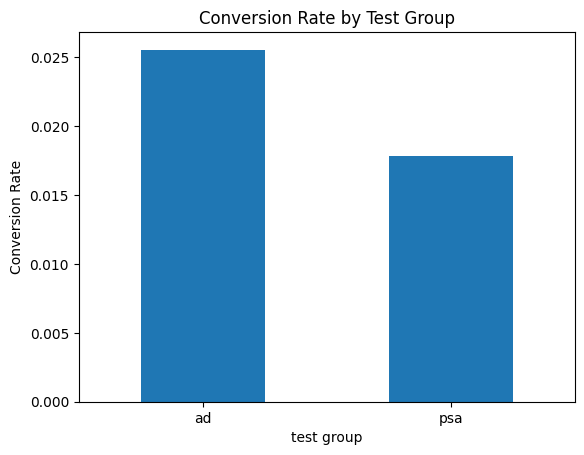

In [9]:
import matplotlib.pyplot as plt

summary["conversion_rate"].plot(
    kind="bar",
    title="Conversion Rate by Test Group",
    ylabel="Conversion Rate",
    rot=0
)
plt.show()


## Conclusion & Recommendation

The ad variant shows a statistically and practically significant uplift
in conversion rate compared to PSA.

Recommendation:
- Roll out the ad variant to 100% of traffic.
- Monitor post-rollout metrics to ensure no novelty effects.